In [1]:
module QuantumRelay

using SymPy
using JuMP
using Clp
using IterTools
using LLLplus
using GSL
using Distributions
using LinearAlgebra
using SmithNormalForm
using SpecialFunctions

export
	qrelay_op,
	op_mat,
	scan_maker,
	nonneg,
	QRelaySampler

include("utility.jl")
include("operators.jl")
include("scan.jl")
include("distributions.jl")

struct QRelaySampler
	prob::Function #return the probablility
	psetproposal::Function #return next combination of sample

    #input parameters:
    #mat: the matrix p_ij in the note (10)
    #coef: the coefficient c in the note (10)
    #omega: the coefficient A in the note (10)
    #pdet0: the probability of detection for each detector
	function QRelaySampler(mat::Array{T, 2}, coef, omega, pdet0) where T <: Int
		F=smith(mat)
		U=F.S
		V=F.T
		S=diagm(F)
        #the SmithNormalForm returns P=USV. Inverse the matrices so Ui/Vi is the same as U/V in the note (18)
		Ui = inv(U) 
		Vi = inv(V)
		s = diag(S)
		r = count(!iszero, s)
		s0 = s[1:r]
		@assert s0 == ones(r)
		ui1 = Ui[1:r, :]
		ui2 = Ui[r+1:end, :]
		vi1 = Vi[:, 1:r]
		vi2 = Vi[:, r+1:end]
		vi2 = lll(vi2)[1] #Lenstra–Lenstra–Lovász lattice basis reduction
		T0 = vi1*ui1
		ui2oc = orthocomp(ui2) #orhogonal complements
		setc, scan = scan_maker(vi2) #make the scanner for the algorithm1 in the note
        
        #compute the probability for an ideal system
        #na: the photon numbers in a output mode
		function prob(na)
		    @assert count(!iszero, ui2*na) == 0
		    b = T0*na
		    setc(-b)
		    total = 0.0
		    for x in Channel(scan)
		        nab = vi2*x + b #the photon numbers for each item in the sum in the note (10)
		        total += prod([c.^complex(n)/gamma(n+1) for (c, n) in zip(coef, nab)])
		    end
		    return abs2(total*omega)
		end

        #compute the probability of detection
        #q: the number of photons detectors report
        #na: the number of photons arrived at detector
        #mask: if there is no detector in this channel, mask=0
		function prob(q, na, mask)
		    q0 = round.(Int, q.>0)
		    m0 = round.(Int, mask)
		    return prod((q0 + (ones(length(q0))-2q0).*pdet0(na)).^m0)
		end

		psetproposal(x::Vector) = QuantumRelay.OrthoNNDist(x, ui2oc)

		new(prob, psetproposal)

	end
end
end

Main.QuantumRelay

In [20]:
using Plots
using Random
using SymPy
using CSV
using DataFrames
using Main.QuantumRelay
using Distributions

#calling the github code 
function quantumrelay(alpha,delta,name::String,n)   #n is the number of sources for 1 relay we have 2 sources
   
    chi = fill(sqrt(0.06), n)                  # the parameter chi 
    phi = im*tanh.(chi)
    omega = -log(prod(cosh.(chi)))
    syms, op = qrelay_op(n, phi, alpha, delta)
    op_a, op_ab, mat, coef = op_mat(op)

    op_q2 = [syms.apH[1], syms.apV[1], syms.bpH[end], syms.bpV[end]]
    op_q1 = [syms.apH[2:end]..., syms.apV[2:end]..., syms.bpH[1:end-1]..., syms.bpV[1:end-1]...]
    mask_q1 = [op in op_q1 for op in op_a];
    
    mask_q2 = [op in op_q2 for op in op_a];
    qq = [x in syms.apH || x in syms.bpV ? 1 : 0 for x in op_a]
           
    pdet0 = pdet_maker(0.04, 3e-5)
    qrs = QRelaySampler(mat, coef, omega, pdet0)
    targetcache=Dict{Vector{Int}, Float64}()
    target(x::Vector)= log(qrs.prob(qq, x, mask_q1))+ log(qrs.prob(x))      #the target function of MCMC
    Iteration=2^17
    burnin=2^10
    samples=Iteration+burnin
    step=5
    save_iter=burnin:samples
    dist= qrs.psetproposal           #the proposal distribution
    selected=[]
    Q = []
    
    current_x = zeros(8)
    @time for i in 2:samples            #from this line the MCMC algorithm starts
        
        proposed_x= rand(dist(current_x))
        
        prop_proposed= logpdf(dist(current_x), proposed_x)
        
        prop_current= logpdf(dist(proposed_x), current_x)
        
        
        A= min(0,target(proposed_x)+prop_current-target(current_x)-prop_proposed)
        
        
        if log(rand()) < A
            if i in save_iter
                
                push!(selected, proposed_x)
                push!(Q, qrs.prob(qq, proposed_x, mask_q2))
            
            end
    
            current_x = proposed_x
        
        end        
    
        
    end
    
    return selected, Q
end

quantumrelay (generic function with 1 method)

In [13]:
prob= []
accepted= []
for i = 0:16
    beta = i*pi/16
    name = string(i)
    selected, Q = quantumrelay(pi/4, beta, name,2)
    push!(accepted,length(selected))
    println("beta:", beta)
    push!(prob,Q)
    df=DataFrame(selected=selected)

end

549.839568 seconds (227.61 M allocations: 14.256 GiB, 22.20% gc time, 0.03% compilation time)
beta:0.0
475.498678 seconds (603.32 M allocations: 37.506 GiB, 2.36% gc time)
beta:0.2243994752564138
392.974357 seconds (575.03 M allocations: 35.755 GiB, 2.31% gc time)
beta:0.4487989505128276
359.730081 seconds (548.75 M allocations: 34.154 GiB, 2.25% gc time)
beta:0.6731984257692414
354.541380 seconds (557.41 M allocations: 34.679 GiB, 2.25% gc time)
beta:0.8975979010256552
361.880311 seconds (574.12 M allocations: 35.708 GiB, 2.29% gc time)
beta:1.121997376282069
377.870224 seconds (604.22 M allocations: 37.559 GiB, 2.31% gc time)
beta:1.3463968515384828
378.074175 seconds (615.92 M allocations: 38.312 GiB, 2.35% gc time)
beta:1.5707963267948966
380.821927 seconds (624.20 M allocations: 38.805 GiB, 2.39% gc time)
beta:1.7951958020513104
444.144503 seconds (608.72 M allocations: 37.876 GiB, 2.40% gc time)
beta:2.019595277307724
369.266172 seconds (597.04 M allocations: 37.176 GiB, 2.39% gc

m = Any[0.0004591674128598995, 0.0005521519513161733, 0.0006274654319783458, 0.0007624169232057143, 0.0007753125834216338, 0.0006383548441118077, 0.0005670666385323372, 0.00045346464670197116, 0.00038618691749740526, 0.00027095512530787575, 0.0002608240713158421, 0.0002315354167953579, 0.000294440069922552, 0.00036591581369093936, 0.00041450577913591477]


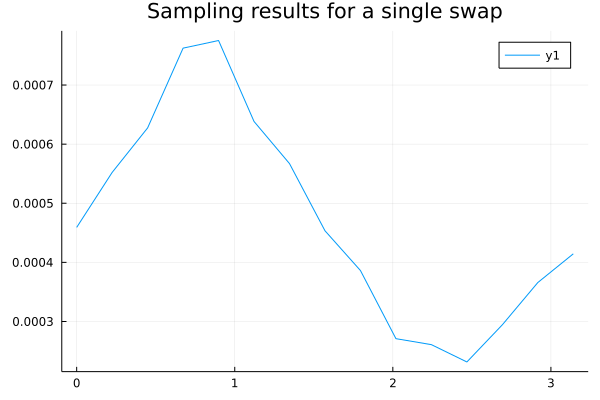

In [14]:

using Statistics
m=[]
for i in 1:length(prob)
    push!(m,mean(prob[i]))
end
beta=[beta = i*pi/14 for i in 0:14]
@show m
Plots.plot(beta, m, title="Sampling results for a single swap")

In [24]:
selected2, Q2 = quantumrelay(pi/4, 3pi/4, "2",2)
mean(Q2)

376.942008 seconds (600.35 M allocations: 37.379 GiB, 2.64% gc time)


0.00025847368012058404

0.0002294785828582617